# Préparation et Chargement des données 

## 1. Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold,SelectPercentile,f_classif
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,precision_score, recall_score, f1_score,precision_recall_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer

## 2. Chargement des datasets 

In [2]:
t_arr = pd.read_csv("in_time.csv")
t_dép = pd.read_csv("out_time.csv")
emp_survey = pd.read_csv("employee_survey_data.csv")
gen_data = pd.read_csv("general_data.csv")
man_survey = pd.read_csv("manager_survey_data.csv")      

## 3. Gestion des valeurs manquantes

### 3.1 Taux de valeurs manquantes

In [3]:
missing_rates1 = t_arr.isna().mean()
print(missing_rates1)

Unnamed: 0    0.000000
2015-01-01    1.000000
2015-01-02    0.047392
2015-01-05    0.046712
2015-01-06    0.051701
                ...   
2015-12-25    1.000000
2015-12-28    0.053061
2015-12-29    0.052154
2015-12-30    0.060091
2015-12-31    0.048299
Length: 262, dtype: float64


In [4]:
missing_rates2 = t_dép.isna().mean()
print(missing_rates2)

Unnamed: 0    0.000000
2015-01-01    1.000000
2015-01-02    0.047392
2015-01-05    0.046712
2015-01-06    0.051701
                ...   
2015-12-25    1.000000
2015-12-28    0.053061
2015-12-29    0.052154
2015-12-30    0.060091
2015-12-31    0.048299
Length: 262, dtype: float64


In [5]:
missing_rates = gen_data.isna().mean()
print(missing_rates)

Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.000000
Department                 0.000000
DistanceFromHome           0.000000
Education                  0.000000
EducationField             0.000000
EmployeeCount              0.000000
EmployeeID                 0.000000
Gender                     0.000000
JobLevel                   0.000000
JobRole                    0.000000
MaritalStatus              0.000000
MonthlyIncome              0.000000
NumCompaniesWorked         0.004308
Over18                     0.000000
PercentSalaryHike          0.000000
StandardHours              0.000000
StockOptionLevel           0.000000
TotalWorkingYears          0.002041
TrainingTimesLastYear      0.000000
YearsAtCompany             0.000000
YearsSinceLastPromotion    0.000000
YearsWithCurrManager       0.000000
dtype: float64


In [6]:
print(man_survey.isna().sum()/t_arr.shape[0])

EmployeeID           0.0
JobInvolvement       0.0
PerformanceRating    0.0
dtype: float64


In [7]:
print(emp_survey.isna().sum()/t_arr.shape[0])

EmployeeID                 0.000000
EnvironmentSatisfaction    0.005669
JobSatisfaction            0.004535
WorkLifeBalance            0.008617
dtype: float64


### 3.2 Nettoyage des données

#### Fonction utilisée pour convertir les durées en minutes

In [8]:
# Fonction pour convertir datetime.time en minutes depuis minuit
def time_to_minutes(time_obj):
    if time_obj is not pd.NaT:  # Vérifie si la valeur n'est pas NaN
        return time_obj.hour * 60 + time_obj.minute + time_obj.second/60
    return None

#### 3.2.1 Nettoyage du dataset des temps d'arrivée

In [9]:
threshold = 0.9
column_to_drop = missing_rates1[missing_rates1>= threshold].index
t_arr_cleaned = t_arr.drop(columns=column_to_drop)
t_arr_cleaned = t_arr_cleaned.drop(columns="Unnamed: 0")
t_arr_cleaned.shape

(4410, 249)

In [10]:
# conversion en date time 
t_arr_cleaned.columns = pd.to_datetime(t_arr_cleaned.columns)
t_arr_converted = t_arr_cleaned.apply(pd.to_datetime)
t_arr_converted = t_arr_converted.apply(lambda col: col.dt.time)

# Appliquer la conversion en minutes sur votre DataFrame
t_arr_minutes = t_arr_converted.applymap(lambda x: time_to_minutes(x))
# Calculer la médiane des minutes pour chaque colonne
medians = t_arr_minutes.median()
# Remplacer les valeurs manquantes par la médiane en minutes
t_arr_seconds_filled = t_arr_minutes.apply(lambda col: col.fillna(medians[col.name]))
# Afficher le DataFrame final avec les valeurs manquantes remplies
t_arr_seconds_filled.head()


C:\Users\brago\AppData\Local\Temp\ipykernel_2976\1368625241.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t_arr_minutes = t_arr_converted.applymap(lambda x: time_to_minutes(x))


,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,...,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,583.750000,608.800000,594.433333,574.516667,591.150000,609.416667,582.883333,613.100000,601.400000,619.133333,...,599.683333,600.116667,595.483333,604.100000,614.450000,611.583333,613.683333,603.600000,594.200000,612.733333
1,615.733333,621.083333,600.016667,585.283333,609.066667,583.433333,600.116667,643.483333,577.950000,597.300000,...,555.133333,637.283333,589.033333,633.850000,612.166667,599.925000,571.750000,595.816667,632.416667,567.333333
2,617.683333,590.833333,614.216667,587.450000,603.666667,605.816667,603.783333,621.433333,595.183333,605.600000,...,593.283333,615.233333,610.466667,584.733333,615.900000,607.433333,582.083333,583.600000,574.083333,628.650000
3,605.100000,596.533333,611.116667,577.500000,602.133333,608.200000,613.700000,593.366667,600.833333,598.100000,...,594.600000,617.633333,598.350000,604.416667,611.766667,583.250000,592.733333,573.266667,618.200000,601.250000
4,628.283333,589.966667,585.466667,589.616667,619.733333,600.833333,629.450000,599.533333,606.200000,603.833333,...,586.583333,598.583333,603.683333,610.500000,613.600000,584.400000,605.250000,630.883333,558.350000,581.150000


####  3.2.2 Nettoyage du dataset des temps de départ

In [11]:
t_dép_cleaned = t_dép.drop(columns= column_to_drop)
t_dép_cleaned = t_dép_cleaned.drop(columns="Unnamed: 0")
t_dép_cleaned.shape

(4410, 249)

In [12]:
# conversion en date time 
t_dép_cleaned.columns = pd.to_datetime(t_dép_cleaned.columns)
t_dép_converted = t_dép_cleaned.apply(pd.to_datetime)
t_dép_converted = t_dép_converted.apply(lambda col: col.dt.time)

# Appliquer la conversion en minutes sur votre DataFrame
t_dép_minutes = t_dép_converted.applymap(lambda x: time_to_minutes(x))
# Calculer la médiane des minutes pour chaque colonne
medians = t_dép_minutes.median()
# Remplacer les valeurs manquantes par la médiane en minutes
t_dép_seconds_filled = t_dép_minutes.apply(lambda col: col.fillna(medians[col.name]))
# Afficher le DataFrame final avec les valeurs manquantes remplies
t_dép_seconds_filled.isna().mean()

C:\Users\brago\AppData\Local\Temp\ipykernel_2976\969997145.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t_dép_minutes = t_dép_converted.applymap(lambda x: time_to_minutes(x))


2015-01-02    0.0
2015-01-05    0.0
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
             ... 
2015-12-24    0.0
2015-12-28    0.0
2015-12-29    0.0
2015-12-30    0.0
2015-12-31    0.0
Length: 249, dtype: float64

#### 3.2.3 Dataset de durée moyenne de travail de chaque employé 

In [13]:
t_durée = t_dép_seconds_filled - t_arr_seconds_filled
t_durée_mean= t_durée.mean(axis=1)
t_durée_mean = t_durée_mean.to_frame(name="worktime_mean")
t_durée_mean.head()

,worktime_mean
0,442.626673
1,462.203648
2,421.505120
3,432.411747
4,479.811145


#### 3.2.4 Nettoyage du dataset des enquêtes sur les employés

In [14]:
emp_survey = emp_survey.fillna(emp_survey.median())
emp_survey.isna().mean()

EmployeeID                 0.0
EnvironmentSatisfaction    0.0
JobSatisfaction            0.0
WorkLifeBalance            0.0
dtype: float64

#### 3.2.5 Nettoyage du dataset gen_data

In [15]:
print(f"Avant :\n{gen_data.isnull().mean()}\n")
gen_data["NumCompaniesWorked"] = gen_data["NumCompaniesWorked"].fillna(gen_data["NumCompaniesWorked"].median())
gen_data["TotalWorkingYears"] = gen_data["TotalWorkingYears"].fillna(gen_data["TotalWorkingYears"].median())
print(f"Après :\n{gen_data.isnull().mean()}")

Avant :
Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.000000
Department                 0.000000
DistanceFromHome           0.000000
Education                  0.000000
EducationField             0.000000
EmployeeCount              0.000000
EmployeeID                 0.000000
Gender                     0.000000
JobLevel                   0.000000
JobRole                    0.000000
MaritalStatus              0.000000
MonthlyIncome              0.000000
NumCompaniesWorked         0.004308
Over18                     0.000000
PercentSalaryHike          0.000000
StandardHours              0.000000
StockOptionLevel           0.000000
TotalWorkingYears          0.002041
TrainingTimesLastYear      0.000000
YearsAtCompany             0.000000
YearsSinceLastPromotion    0.000000
YearsWithCurrManager       0.000000
dtype: float64

Après :
Age                        0.0
Attrition                  0.0
BusinessTravel             0.0
Department 

#### 3.3 Concatenation du dataset résultant « t_durée » avec gen_data et les data-set surveys

In [16]:
result = pd.concat([gen_data, man_survey, emp_survey,t_durée_mean], axis=1)
result_final = result.loc[:, ~result.columns.duplicated()]
result_final.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,442.626673
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,462.203648
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,421.505120
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,432.411747
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,479.811145


#### 3.4 Encodage et Normalisation des données

##### 3.4.1 Encodage des données

In [17]:
result_final_cat = result_final[['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','Over18']]
encoder = OneHotEncoder(sparse_output=False)
result_final_cat_prepared = encoder.fit_transform(result_final_cat)
attrition = pd.DataFrame({
    'Attrition': result_final['Attrition'].replace({'Yes': 1, 'No': 0})
})
result_final_encoded = pd.DataFrame(result_final_cat_prepared, columns=encoder.get_feature_names_out(input_features=result_final_cat.columns))
result_final_encoded.head()

C:\Users\brago\AppData\Local\Temp\ipykernel_2976\4029410223.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'Attrition': result_final['Attrition'].replace({'Yes': 1, 'No': 0})


,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


##### 3.4.2 Normalisation des données 

In [18]:
imputer = SimpleImputer(strategy="median")
result_final_num = result_final.select_dtypes(include=['number'])
scaler = StandardScaler()
result_final_scaled = pd.DataFrame(scaler.fit_transform(result_final_num), columns=result_final_num.columns)
result_final_scaled.head()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,2.483396,-0.981014,-0.679146,-1.155935,0.379672,-0.426230,0.252200,1.156302,-1.085336,-0.247733
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.155707,-0.327893,-0.368715,-0.034520,-1.026167,2.346151,0.252200,-0.663899,1.757749,0.007296
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,-0.620189,-0.327893,-0.679146,-0.314873,0.379672,-0.426230,-0.665460,-0.663899,-2.506879,-0.522883
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,1.707500,0.161947,1.493867,0.245834,-1.026167,-0.426230,1.169861,1.156302,0.336206,-0.380802
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,-0.620189,-0.164613,-0.679146,-0.034520,0.379672,-0.426230,1.169861,-1.573999,0.336206,0.236668


##### 3.4.3 Dataset final normalisé et encodé 

In [19]:
finalresult = pd.concat([result_final_scaled,result_final_encoded,attrition], axis=1)
finalresult.head()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,Attrition
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


# Exploration et Visualisation des données 

## 1. Analyse de la variable cible 

C:\Users\brago\AppData\Local\Temp\ipykernel_2976\957190856.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attrition', data=finalresult, palette=['steelblue','orange'])


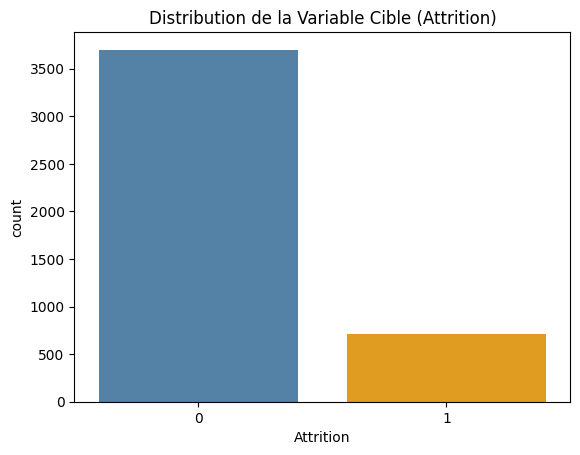

In [20]:
sns.countplot(x='Attrition', data=finalresult, palette=['steelblue','orange'])
plt.title('Distribution de la Variable Cible (Attrition)')
plt.show()

In [21]:
finalresult['Attrition'].value_counts(normalize=True)

Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

 On remarque que nos classes ne sont pas équilibrées pour ce problème en effet on a 16% d'employés qui ont quitté l'entreprise donc on ne peut pas se fier uniquement à la précision, on va devoir utiliser les métriques F1-score , ROC-AUC et précision-rappel AUC pour évaluer les performances 

## 2. Visualisation des variables numériques

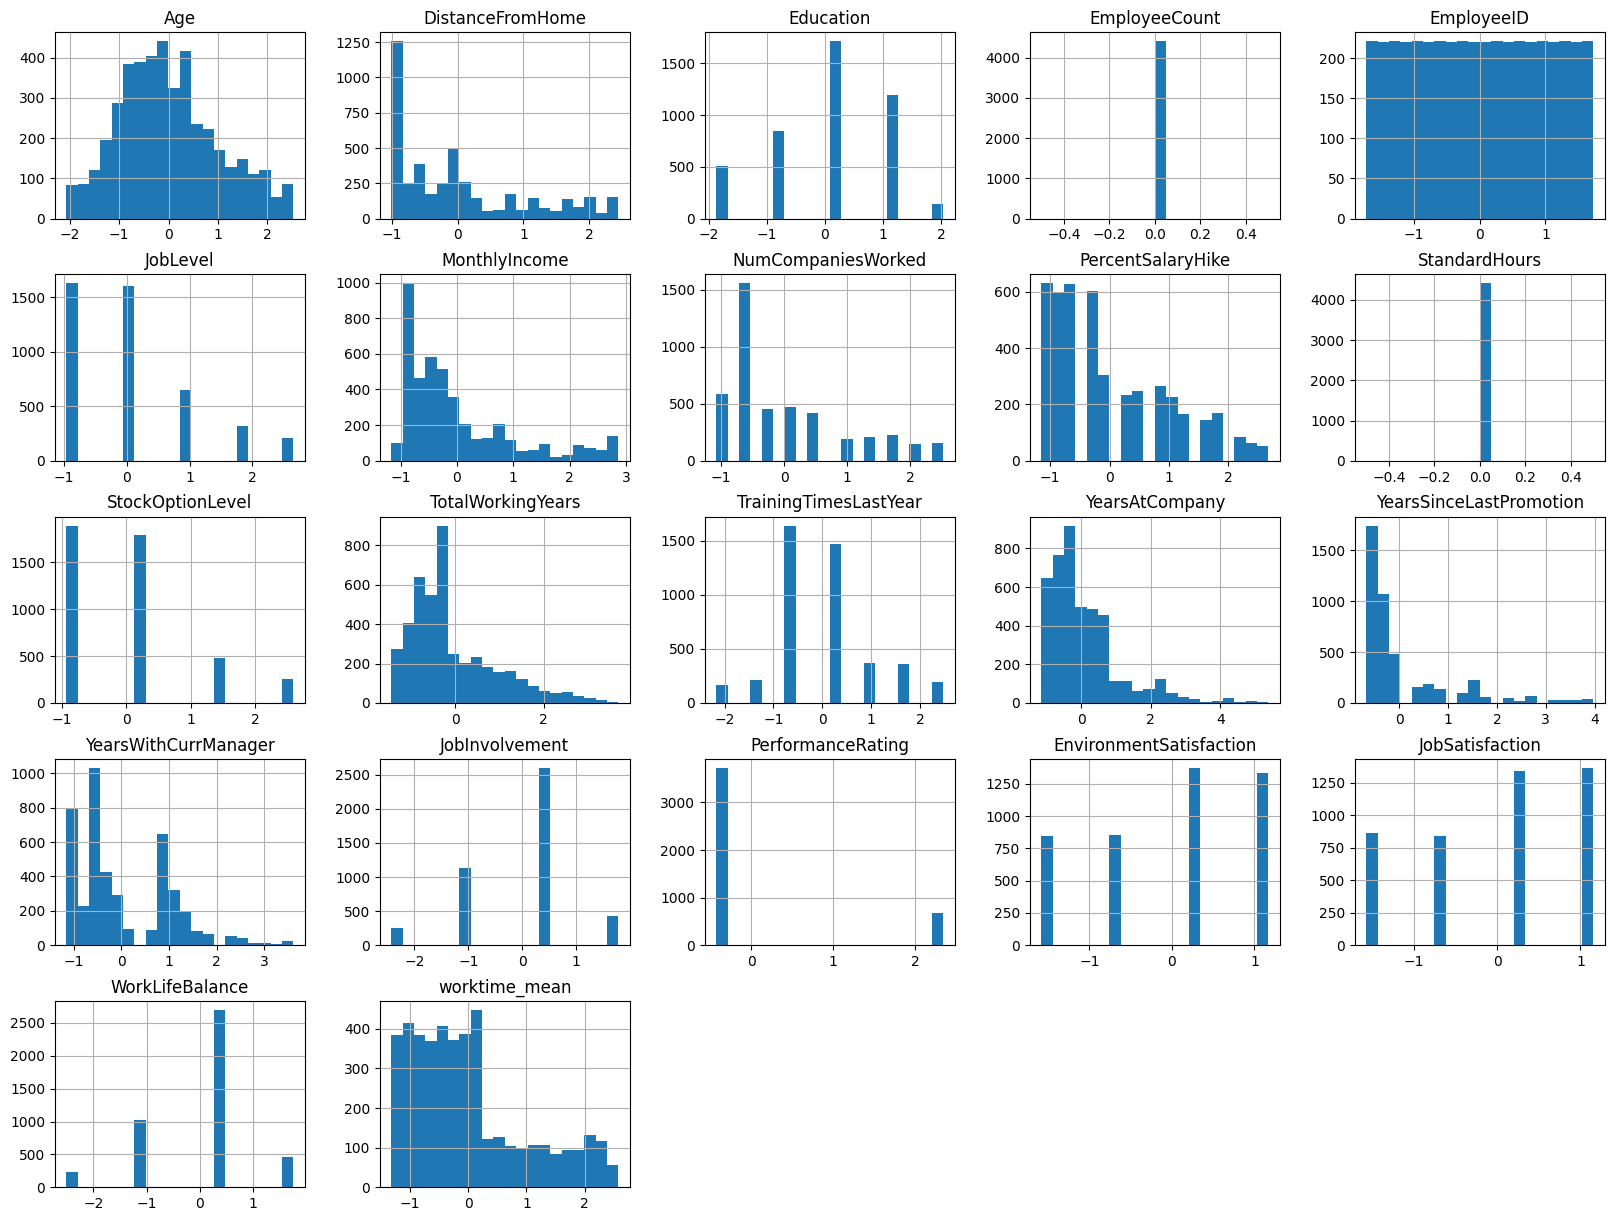

In [22]:
result_final_scaled.hist(bins=20, figsize=(20, 15))
plt.show()

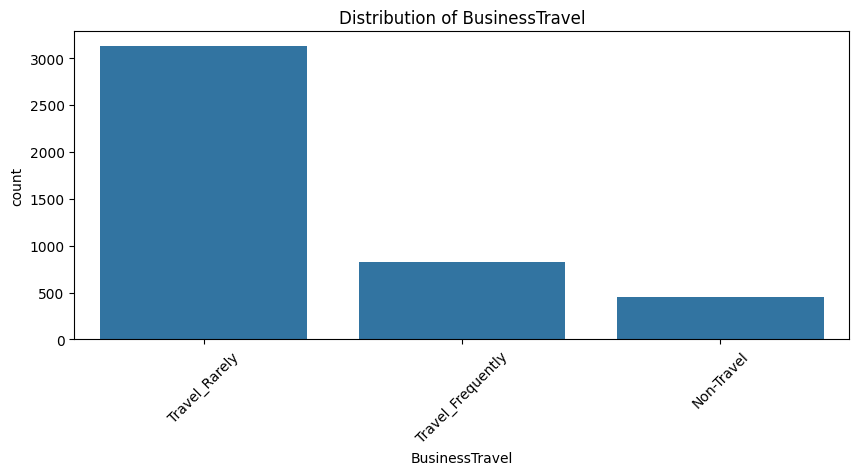

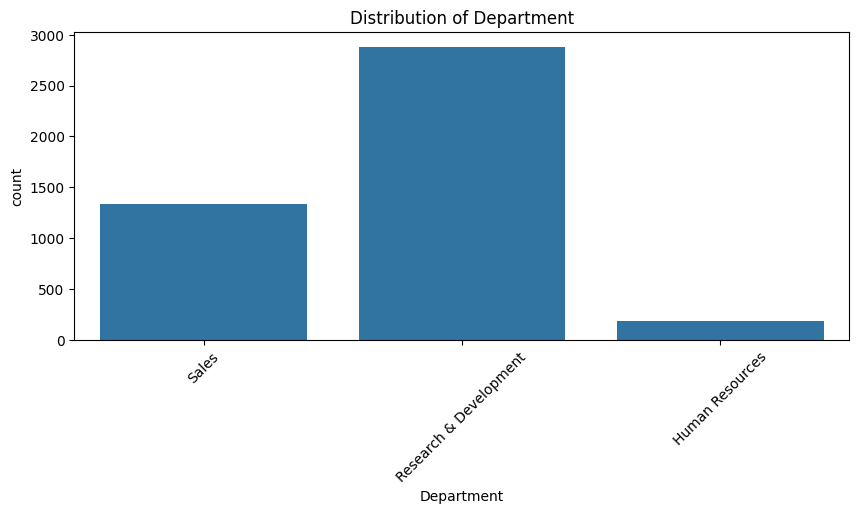

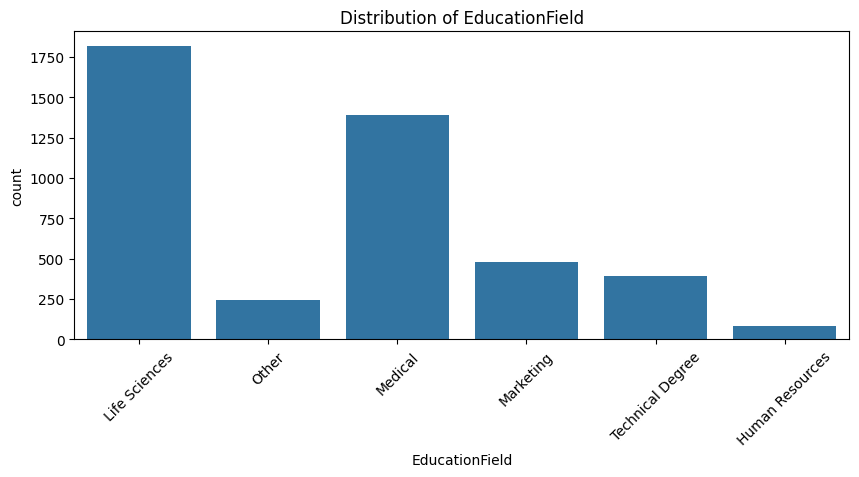

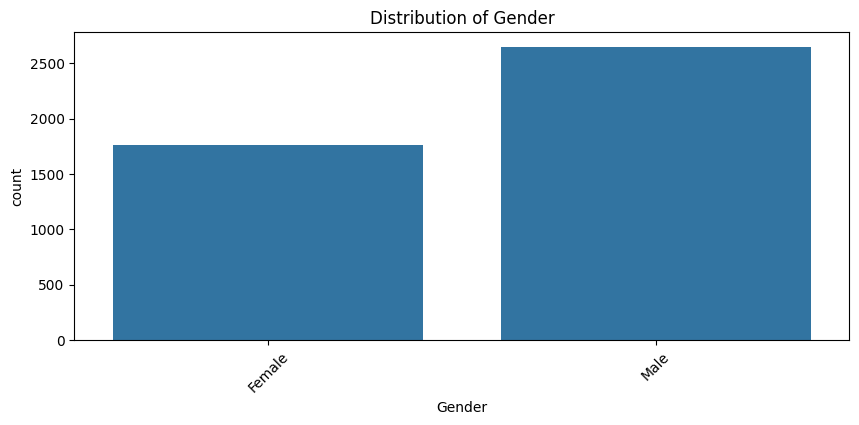

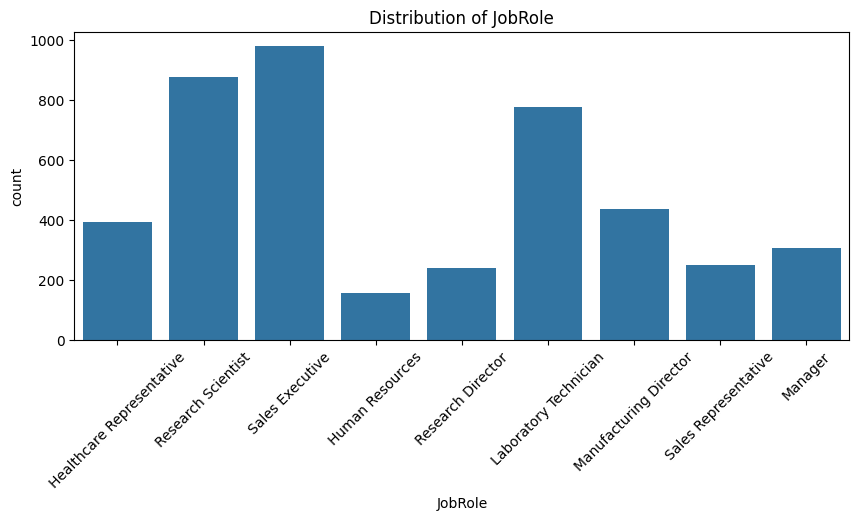

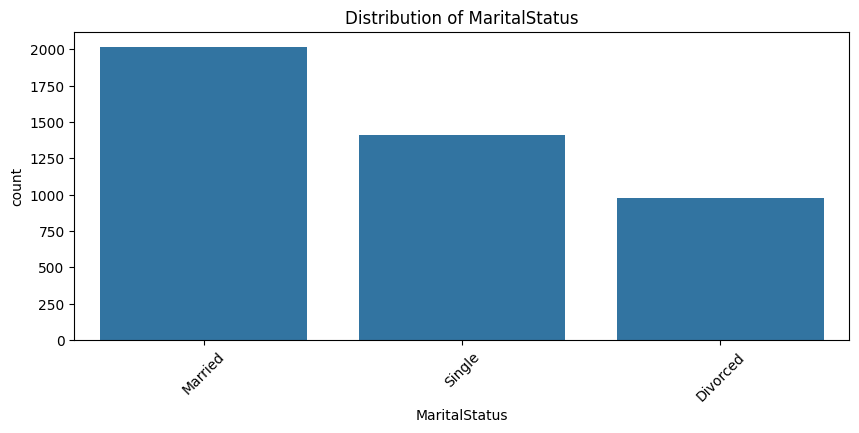

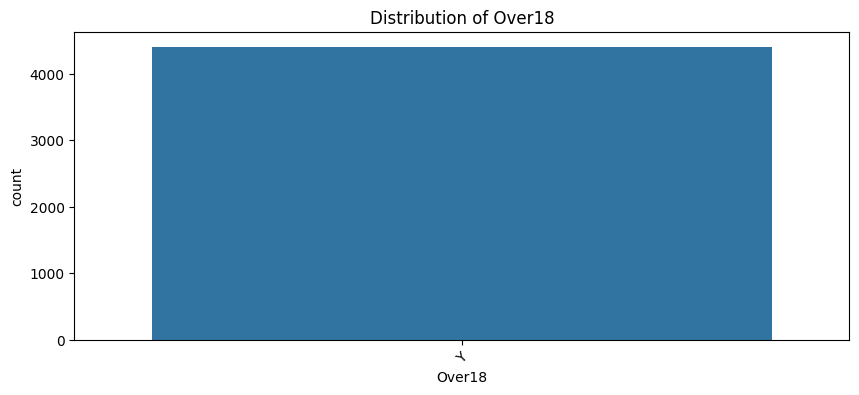

In [23]:
for col in result_final_cat.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=result_final_cat[col])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

## 3. Matrice de corrélation

<Axes: >

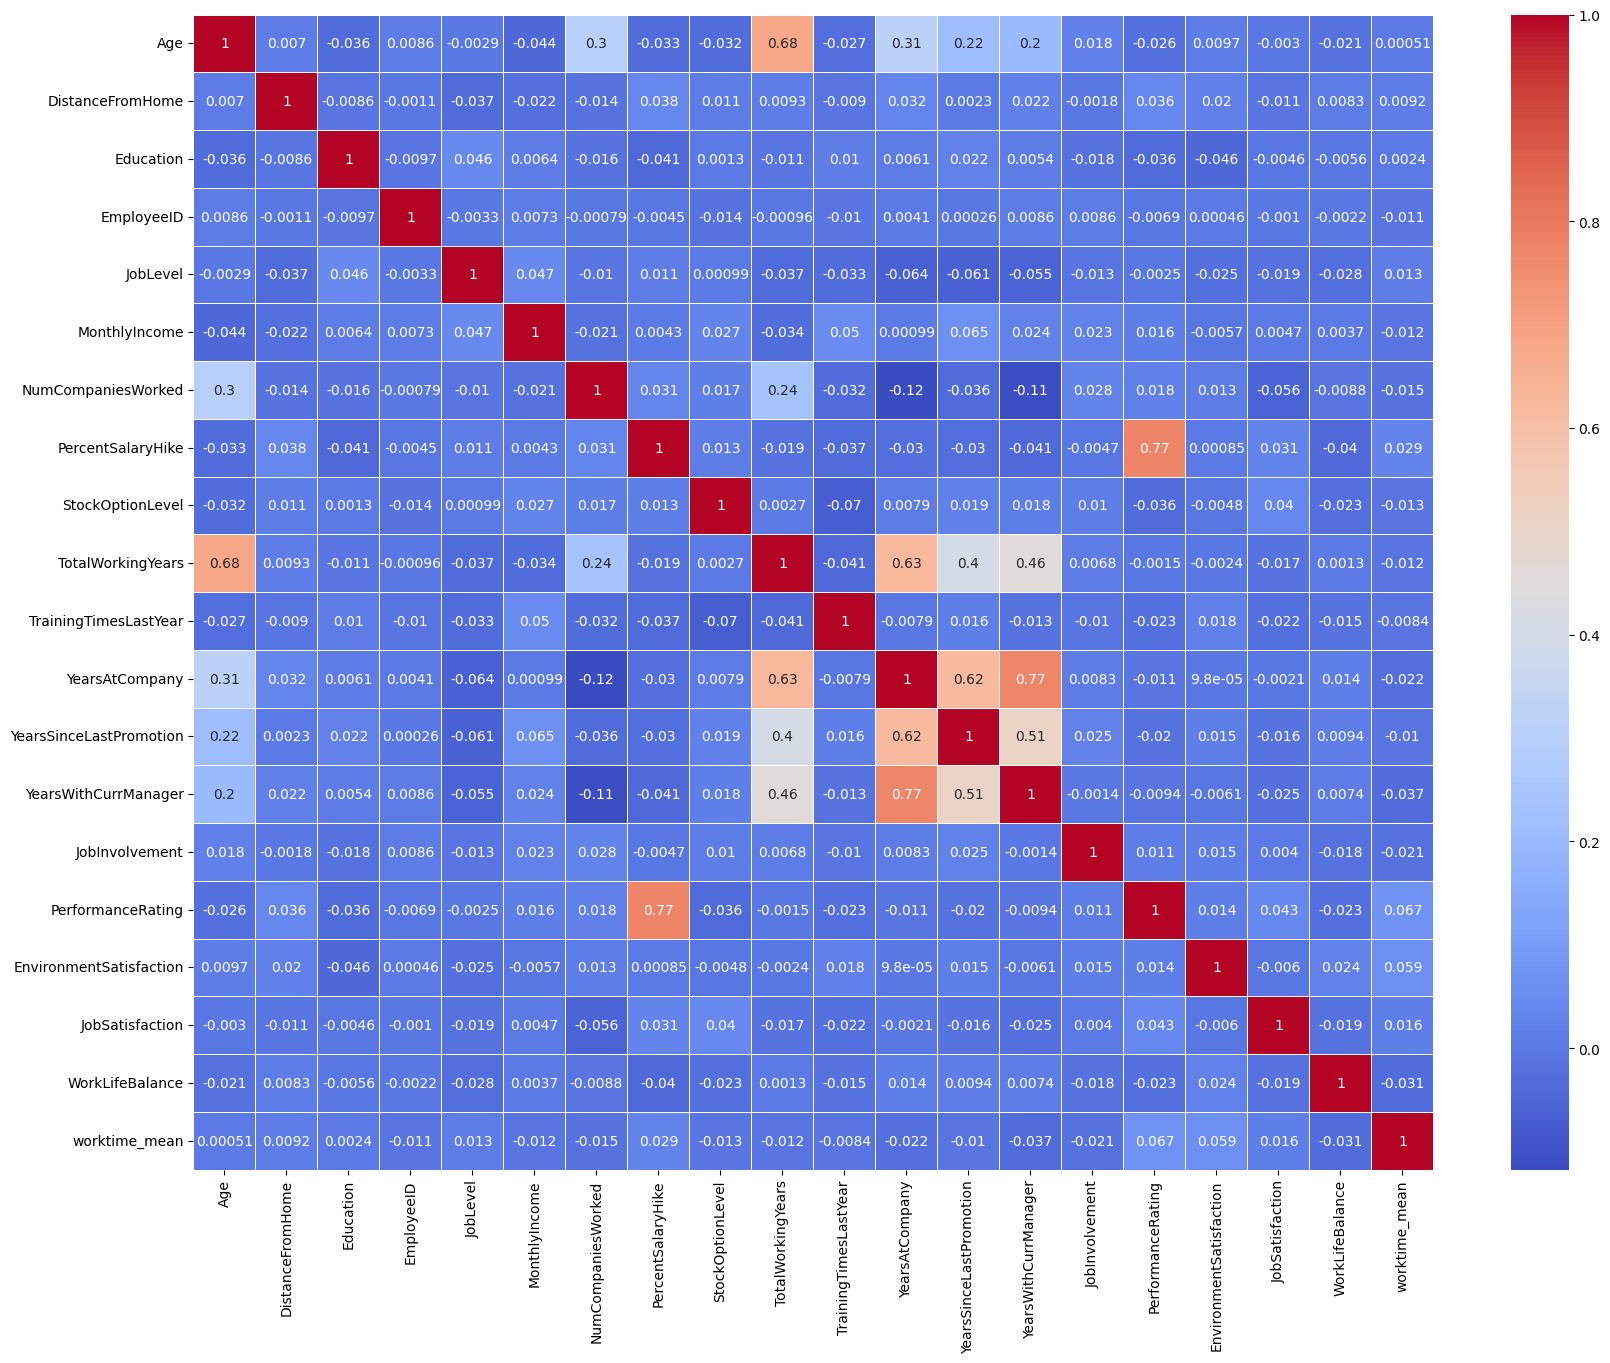

In [24]:
plt.figure(figsize=(20,15))
sns.heatmap(result_final_scaled.drop(columns=["EmployeeCount","StandardHours"]).corr(), annot=True, cmap='coolwarm' ,linewidths=0.5)

Dans cette matrice on observe les corrélations entre les différentes features.
Les features ne corrèlent pas à plus de **0.85** donc on peut conserver ces features 

## 4. Sélection des variables pour le modèle

### 4.1 Définition de la variable cible et les variables pour le modèle

In [25]:
y = finalresult["Attrition"]
X = finalresult.drop(columns="Attrition")

### 4.2 Test de dépendance des variables

c:\Users\brago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 3  9 48] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\brago\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\brago\AppData\Local\Temp\ipykernel_2976\3542410838.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=df_scores_filled.sort_values(by='Score', ascending=False), palette="coolwarm")


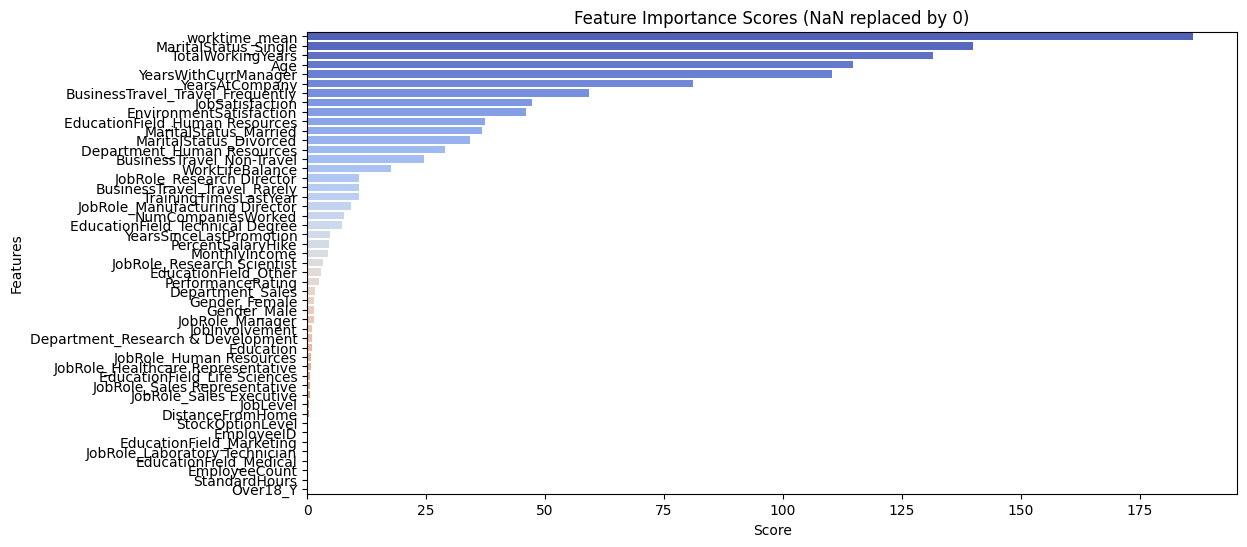

In [26]:
selecteur = SelectPercentile(f_classif,percentile=50)
selecteur.fit_transform(X, y)


scores = selecteur.scores_
features = X.columns
pd.set_option('display.max_rows', None)
# Créer un DataFrame pour mieux visualiser
df_scores = pd.DataFrame({'Feature': features, 'Score': scores})
df_scores = df_scores.sort_values(by='Score', ascending=False)

# Remplacement de  NaN par 0
df_scores_filled = df_scores.fillna(0)

# Graphe 
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Feature', data=df_scores_filled.sort_values(by='Score', ascending=False), palette="coolwarm")
plt.title('Feature Importance Scores (NaN replaced by 0)')
plt.xlabel('Score')
plt.ylabel('Features')
plt.show()


### 4.3 Sélection des variables

#### 4.3.1 On garde la moitié des variables avec la plus grande dépendance avec la target

In [27]:
avant = np.array(X.columns)
reste = np.array(X.columns)[selecteur.get_support()]
print(f"Avant on avait : {len(avant)} colonnes mais maintenant il n'en reste que {len(reste)}")
print(f'\n {reste}')
X = X[reste]

Avant on avait : 49 colonnes mais maintenant il n'en reste que 24

 ['Age' 'MonthlyIncome' 'NumCompaniesWorked' 'PercentSalaryHike'
 'TotalWorkingYears' 'TrainingTimesLastYear' 'YearsAtCompany'
 'YearsSinceLastPromotion' 'YearsWithCurrManager'
 'EnvironmentSatisfaction' 'JobSatisfaction' 'WorkLifeBalance'
 'worktime_mean' 'BusinessTravel_Non-Travel'
 'BusinessTravel_Travel_Frequently' 'BusinessTravel_Travel_Rarely'
 'Department_Human Resources' 'EducationField_Human Resources'
 'EducationField_Technical Degree' 'JobRole_Manufacturing Director'
 'JobRole_Research Director' 'MaritalStatus_Divorced'
 'MaritalStatus_Married' 'MaritalStatus_Single']


#### 4.3.2 On écarte les variables avec une variance inférieure à 0.1

In [28]:
selector = VarianceThreshold(threshold=0.1)
selector.fit_transform(X)
reste = np.array(X.columns)[selector.get_support()]
print(f'Il nous reste {len(reste)} colonnes')
print(f'\n {reste}')
X = X[reste]

Il nous reste 18 colonnes

 ['Age' 'MonthlyIncome' 'NumCompaniesWorked' 'PercentSalaryHike'
 'TotalWorkingYears' 'TrainingTimesLastYear' 'YearsAtCompany'
 'YearsSinceLastPromotion' 'YearsWithCurrManager'
 'EnvironmentSatisfaction' 'JobSatisfaction' 'WorkLifeBalance'
 'worktime_mean' 'BusinessTravel_Travel_Frequently'
 'BusinessTravel_Travel_Rarely' 'MaritalStatus_Divorced'
 'MaritalStatus_Married' 'MaritalStatus_Single']


In [29]:
X.head()

,Age,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1.541369,1.405136,-0.678464,-1.150554,-1.322079,2.483396,-0.981014,-0.679146,-1.155935,0.252200,1.156302,-1.085336,-0.247733,0.0,1.0,0.0,1.0,0.0
1,-0.648668,-0.491661,-1.079486,2.129306,-0.678877,0.155707,-0.327893,-0.368715,-0.034520,0.252200,-0.663899,1.757749,0.007296,1.0,0.0,0.0,0.0,1.0
2,-0.539166,2.725053,-0.678464,-0.057267,-0.807517,-0.620189,-0.327893,-0.679146,-0.314873,-0.665460,-0.663899,-2.506879,-0.522883,1.0,0.0,0.0,1.0,0.0
3,0.117845,0.386301,0.123580,-1.150554,0.221606,1.707500,0.161947,1.493867,0.245834,1.169861,1.156302,0.336206,-0.380802,0.0,0.0,0.0,1.0,0.0
4,-0.539166,-0.884109,0.524602,-0.877232,-0.292956,-0.620189,-0.164613,-0.679146,-0.034520,1.169861,-1.573999,0.336206,0.236668,0.0,1.0,0.0,0.0,1.0


# Modélisation 

# 1. Préparation des données d'apprentissage 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# 2. Entraînement et prédicition 

In [31]:
models = {
    "Perceptron": Perceptron(),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Entraînement et prédiction
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# 3. Principales métriques 

In [40]:
scores = []

for name, y_pred in predictions.items():
    y_proba = models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba") else None
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    scores.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': auc_score
    })

scores_df = pd.DataFrame(scores)
print(scores_df)



                Model  Precision    Recall  F1 Score       AUC
0          Perceptron   0.350877  0.141844  0.202020       NaN
1  LogisticRegression   0.672727  0.262411  0.377551  0.771049
2                 SVM   0.882353  0.425532  0.574163  0.886554
3                 KNN   0.513043  0.418440  0.460938  0.924044
4        DecisionTree   0.930070  0.943262  0.936620  0.964884
5        RandomForest   0.978261  0.957447  0.967742  0.999569


# 4. Affichage des matrices de confusion

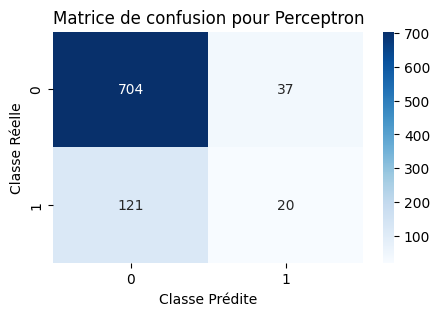

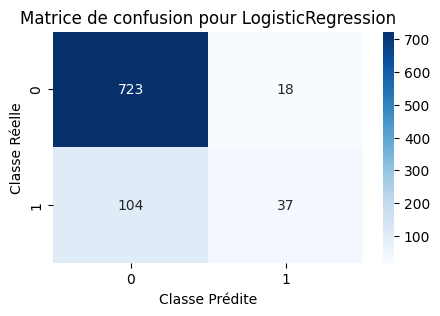

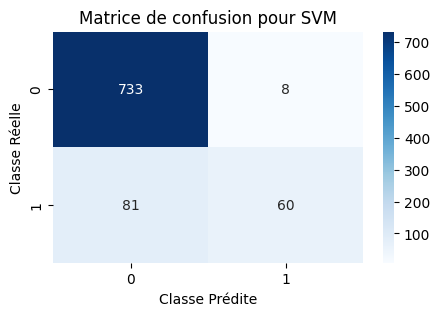

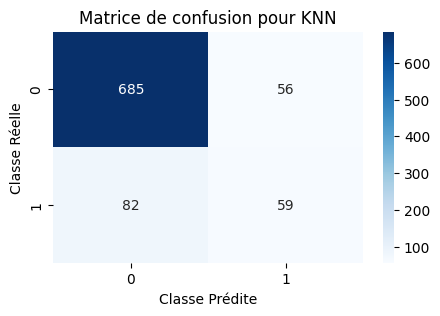

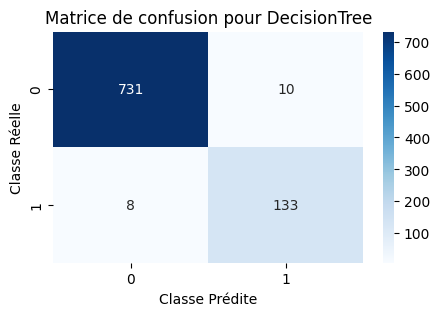

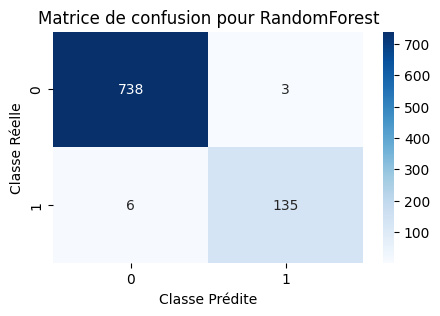

In [33]:
for name, y_pred in predictions.items():
   matrix = confusion_matrix(y_test, y_pred)
   plt.figure(figsize=((5,3)))
   sns.heatmap(matrix, annot=True, cmap='Blues', fmt="")
   plt.title(f'Matrice de confusion pour {name}')
   plt.xlabel("Classe Prédite")
   plt.ylabel("Classe Réelle")


# 5. Affichage des courbes de précision-Rappel

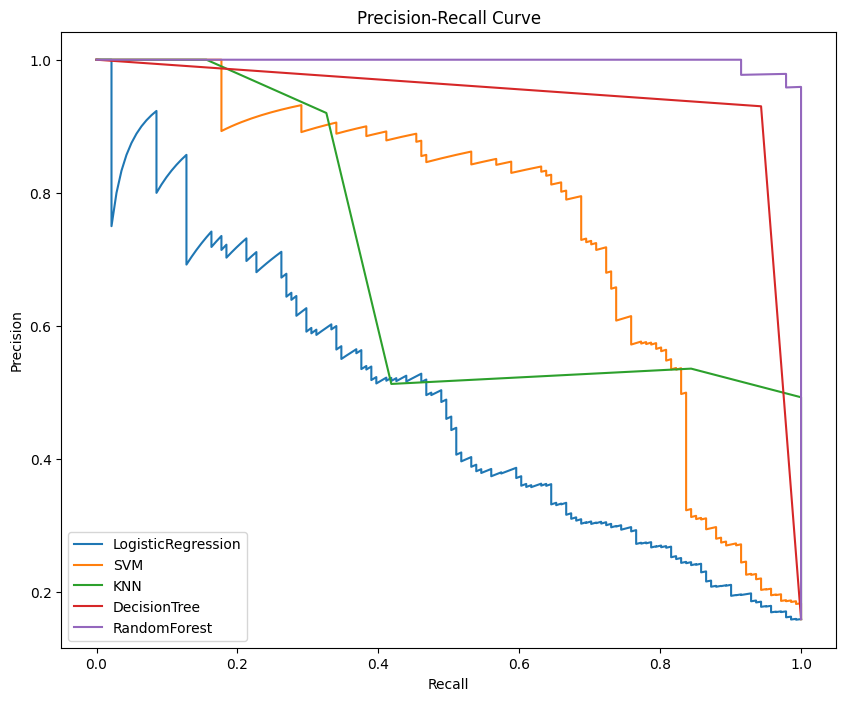

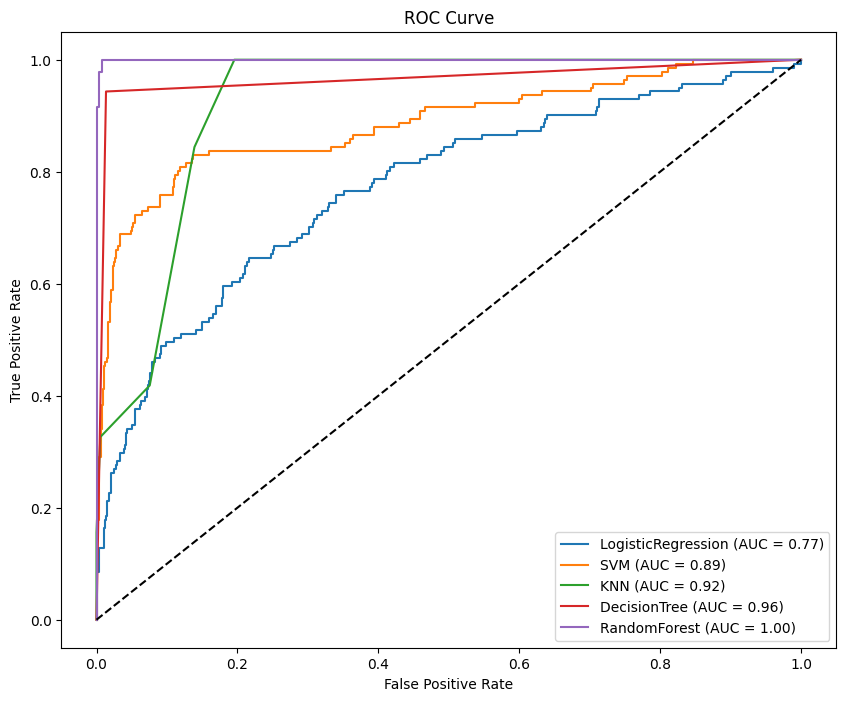

In [34]:
# Tracer les courbes de Précision-Rappel
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 6. Analyse des résultats 

La target de notre modèle est l'attrition : "est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?"
la valeur 0 signifie **qu'il est resté dans l'entreprise en 2016** et 1 **qu'il a quitté l'entreprise en 2016** 

**Explication des métriques :**

VP : le modèle a prédit 1 et le résultat était 1 <=> le modèle a correctement prédit que l'employé a quitté l'entreprise en 2016
FP : le modèle a prédit 1 et le résultat était 0 <=> le modèle a prédit que l'employé a quitté l'entreprise alors qu'il est resté (plus grande)
VN : le modèle a prédit 0 et le résultat était 0 <=> le modèle a correctement prédit que l'employé est resté dans l'entreprise en 2016
FN : le modèle a prédit 0 et le résultat était 1 <=> le modèle a prédit que l'employé est resté dans l'entreprise alors qu'il l'a quittée en 2016 (plus petite)